In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import sys
import os
# Get the parent directory and add it to sys.path
parent_dir = os.path.abspath("..")
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

NicoSchreiberGIT — 11:23
Also ich bin stark für den df_30 da man dort super erkennt wie gut Sarima und PACF für die ersten Tage predicted, Prophet aber die Tage danach besser predicted. Ich wäre dann dafür dass wie PACF, SARIMA, Prophet und CNN2 (performed auch ganz gut) zeigen.
Falls ihr nichts dagegen habt könntest du @Laura Brylka die Grafiken nochmal erstellen mit ylim=(1.85,2.03)/(1.86,2.02) je nachdem was besser aussieht. Und zudem wäre es besser wenn die legende unten links wäre.

# Metric Analysis

### Prepare the data

In [ ]:
df_metrics_baseline = pd.read_csv('../data/models-eval/baseline-model.csv')
df_metrics_pacf = pd.read_csv('../data/models-eval/nico-pacf-model.csv')
df_metrics_prophet = pd.read_csv('../data/models-eval/anton-prophet-model.csv')
df_metrics_sarima = pd.read_csv('../data/models-eval/anton-sarima-model.csv')
df_metrics_cnn = pd.read_csv('../data/models-eval/laura-cnn-small-model.csv')
df_metrics_cnn_lstm = pd.read_csv('../data/models-eval/laura-cnn-lstm-model.csv')

# columns to drop
cols_keep = ['Duration', 'r2_1_day', 'mae_3_day', 'mae_7_day', 'r2_1_day',
       'r2_3_day', 'r2_7_day', 'rmse_1_day', 'rmse_3_day', 'rmse_7_day',
       'dataset']

df_metrics_baseline = df_metrics_baseline[cols_keep]
df_metrics_pacf = df_metrics_pacf[cols_keep]
df_metrics_prophet = df_metrics_prophet[cols_keep]
df_metrics_sarima = df_metrics_sarima[cols_keep]
df_metrics_cnn = df_metrics_cnn[cols_keep]
df_metrics_cnn_lstm = df_metrics_cnn_lstm[cols_keep]

# data to delete
datasets_delete = ['df06', 'df19', 'df20', 'df29']

# drop the datasets (did not work in a loop for some reason)
df_metrics_baseline = df_metrics_baseline[~df_metrics_baseline['dataset'].isin(datasets_delete)]
df_metrics_pacf = df_metrics_pacf[~df_metrics_pacf['dataset'].isin(datasets_delete)]
df_metrics_prophet = df_metrics_prophet[~df_metrics_prophet['dataset'].isin(datasets_delete)]
df_metrics_sarima = df_metrics_sarima[~df_metrics_sarima['dataset'].isin(datasets_delete)]
df_metrics_cnn = df_metrics_cnn[~df_metrics_cnn['dataset'].isin(datasets_delete)]
df_metrics_cnn_lstm = df_metrics_cnn_lstm[~df_metrics_cnn_lstm['dataset'].isin(datasets_delete)]

# attach a column that specifies the model
df_metrics_baseline['model'] = 'baseline'
df_metrics_pacf['model'] = 'pacf'
df_metrics_prophet['model'] = 'prophet'
df_metrics_sarima['model'] = 'sarima'
df_metrics_cnn['model'] = 'cnn'
df_metrics_cnn_lstm['model'] = 'cnn_lstm'

# concatenate the dataframes
df_metrics = pd.concat([
    df_metrics_baseline,
    df_metrics_pacf,
    df_metrics_prophet,
    df_metrics_sarima,
    df_metrics_cnn,
    df_metrics_cnn_lstm
], ignore_index=True)

# we drop nans
df_metrics.dropna(inplace=True)

# convert the duration column
def convert_duration(value):
    if value.endswith('ms'):
        return float(value[:-2]) / 1000  # convert ms to seconds
    elif value.endswith('s'):
        return float(value[:-1])  # already seconds
    elif value.endswith('min'):
        return float(value[:-3]) * 60  # convert minutes to seconds
    else:
        return None  # if unknown format

df_metrics['Duration_sec'] = df_metrics['Duration'].apply(convert_duration)
df_metrics_clean = df_metrics.drop(columns=['Duration']).copy()

for col in ['r2_1_day', 'r2_3_day', 'r2_7_day']:
    df_metrics_clean[col] = (
        df_metrics_clean[col]
        .astype(str)
        .str.replace("'", "", regex=False)
        .str.replace('"', '', regex=False)
        .astype(float)
    )


### Make a pivot table

In [5]:
# calculate metrics in cents
for col in ['mae_1_day', 'mae_3_day', 'mae_7_day', 'rmse_1_day', 'rmse_3_day', 'rmse_7_day']:
    df_metrics_clean[col] = df_metrics_clean[col] * 100

pivot = df_metrics_clean.pivot_table(
    index='model',
    values=['mae_1_day', 'mae_3_day', 'mae_7_day', 
            'r2_1_day', 'r2_3_day', 'r2_7_day',
            'rmse_1_day', 'rmse_3_day', 'rmse_7_day',
            'Duration_sec'],
    aggfunc=['mean']
)



pivot.round(3).to_csv('../data/models-eval/model_performance_summary.csv')
pivot.round(3).to_html('../data/models-eval/model_performance_summary.html')



In [6]:
pivot.columns

MultiIndex([('mean', 'Duration_sec'),
            ('mean',    'mae_1_day'),
            ('mean',    'mae_3_day'),
            ('mean',    'mae_7_day'),
            ('mean',     'r2_1_day'),
            ('mean',     'r2_3_day'),
            ('mean',     'r2_7_day'),
            ('mean',   'rmse_1_day'),
            ('mean',   'rmse_3_day'),
            ('mean',   'rmse_7_day')],
           )

In [ ]:
# Define your mapping from the multi-index to flat names
col_map = {
    ('mean', 'mae_1_day'): 'mae_1_day',
    ('mean', 'r2_3_day'): 'r2_3_day',
    ('mean', 'r2_7_day'): 'r2_7_day',
    ('mean', 'r2_1_day'): 'r2_1_day',
    ('mean', 'r2_3_day'): 'r2_3_day',
    ('mean', 'r2_7_day'): 'r2_7_day',
    ('mean', 'rmse_1_day'): 'rmse_1_day',
    ('mean', 'rmse_3_day'): 'rmse_3_day',
    ('mean', 'rmse_7_day'): 'rmse_7_day',
    ('mean', 'Duration_sec'): 'Duration_sec'
}

# Rename columns using the mapping
pivot = pivot.rename(columns=col_map)
# Reset index so 'model' is a column
pivot = pivot.reset_index()

# Flatten MultiIndex columns (ignore empty second level)
pivot.columns = [col if isinstance(col, str) else col[1] if col[1] != '' else col[0] for col in pivot.columns.values]


In [8]:
pivot.columns

Index(['model', 'Duration_sec', 'mae_1_day', 'mae_3_day', 'mae_7_day',
       'r2_1_day', 'r2_3_day', 'r2_7_day', 'rmse_1_day', 'rmse_3_day',
       'rmse_7_day'],
      dtype='object')

### Plot the data

code used for all plots

In [9]:
model_display_names = {
    'baseline': 'Baseline',
    'pacf': 'PACF',
    'prophet': 'Prophet',
    'sarima': 'SARIMA',
    'cnn': 'CNN',
    'cnn_lstm': 'CNN-LSTM'
}

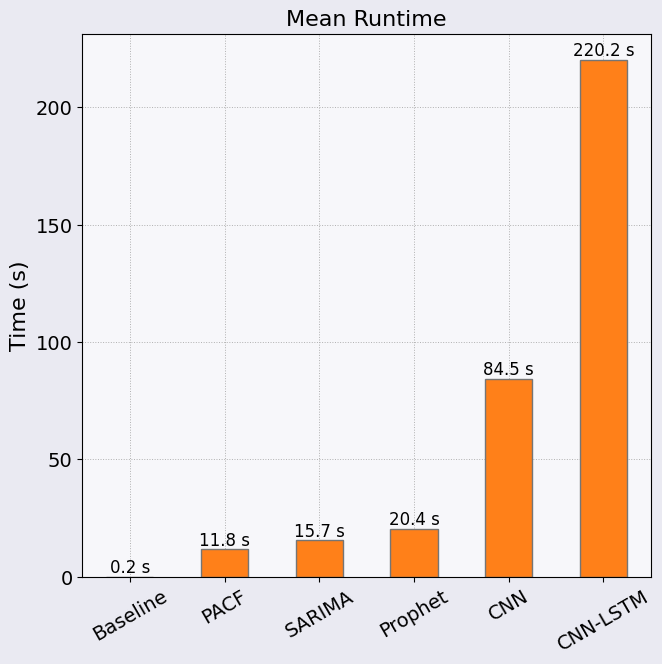

In [39]:
# Get the data to plot and rename index
duration_series = pivot.set_index('model')['Duration_sec'].sort_values()
duration_series.index = [model_display_names.get(idx, idx) for idx in duration_series.index]

plt.figure(figsize=(7, 7))
ax = duration_series.plot(kind='bar', color='#ff8019', edgecolor="#757575", zorder=2)
plt.title('Mean Runtime', fontsize=16)
#plt.legend(fontsize=12, title_fontsize=14, loc='upper left', frameon=True, fancybox=True, shadow=True)
plt.xticks(rotation=30, ha='center', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Time (s)', fontsize=16)
plt.tight_layout(pad=2)
plt.gca().set_facecolor('#f7f7fa')
plt.gcf().patch.set_facecolor('#eaeaf2')
plt.grid(True, which='both', axis='y', linestyle=':', linewidth=0.7, zorder=1)
plt.grid(True, which='both', axis='x', linestyle=':', linewidth=0.7, zorder=1)

# Annotate bars with duration values
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f} s", 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12, color='black', rotation=0)

plt.show()


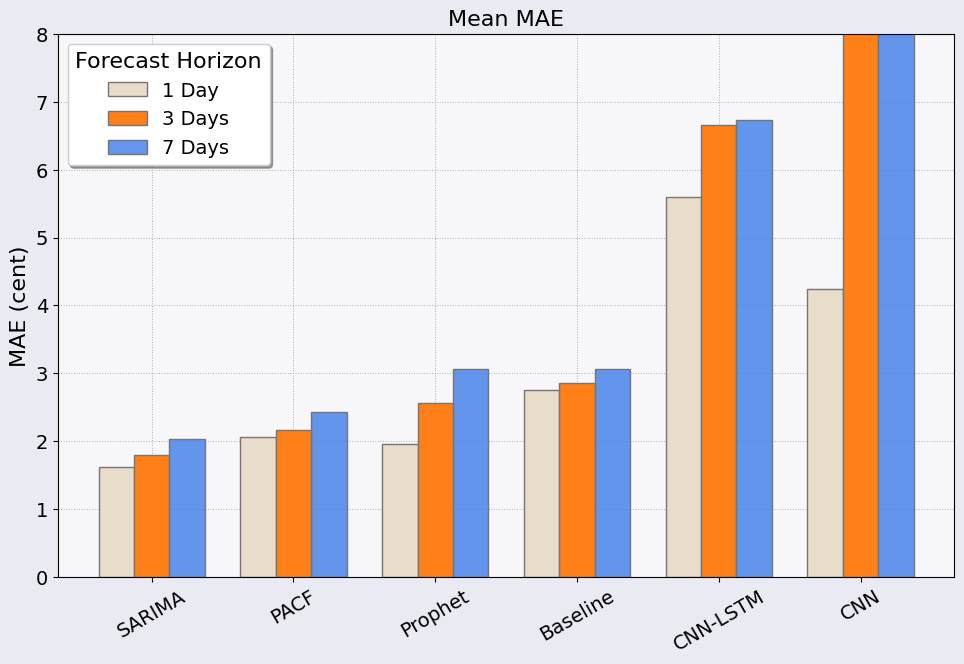

In [11]:
# Define which columns to plot and their display names/colors
mae_days = ['mae_1_day', 'mae_3_day', 'mae_7_day']
labels = ['1 Day', '3 Days', '7 Days']
colors = ["#e8dcca", '#ff8019', "#4380ead2"] 

# Sort by mae_1_day for model order
pivot_sorted = pivot.sort_values('mae_7_day')
model_order = list(pivot_sorted['model'])
model_names = [model_display_names.get(m, m) for m in model_order]
mae_values = [pivot_sorted[col].values for col in mae_days]
x = np.arange(len(model_order))  # label locations
width = 0.25  # width of the bars

plt.figure(figsize=(10, 7))
for i, (mae, color, label) in enumerate(zip(mae_values, colors, labels)):
    plt.bar(x + i*width - width, mae, width, label=label, color=color, edgecolor="#757575", zorder=2)
plt.grid(True, which='both', axis='y', linestyle=':', linewidth=0.7, zorder=1)
plt.grid(True, which='both', axis='x', linestyle=':', linewidth=0.7, zorder=1)
plt.xticks(x, model_names, rotation=30, ha='center', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('MAE (cent)', fontsize=16)
plt.ylim(0, 8)
plt.title('Mean MAE', fontsize=16)
plt.legend(title='Forecast Horizon', fontsize=14, title_fontsize=16, loc='upper left', frameon=True, fancybox=True, shadow=True)
plt.tight_layout(pad=2)
plt.gca().set_facecolor('#f7f7fa')
plt.gcf().patch.set_facecolor('#eaeaf2')

plt.show()

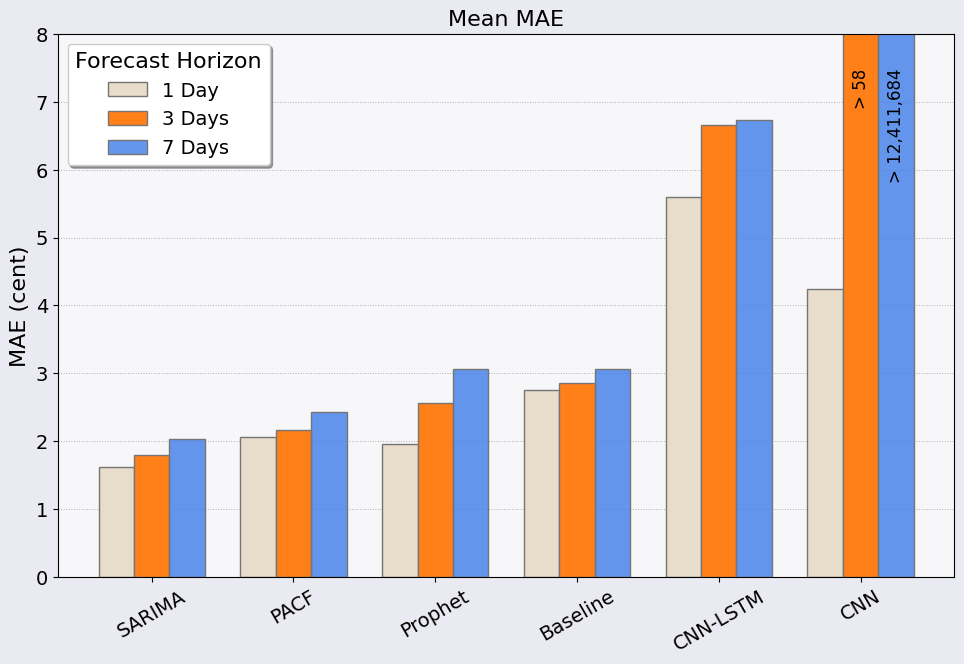

In [12]:
# Setup (same as before)
mae_days = ['mae_1_day', 'mae_3_day', 'mae_7_day']
labels = ['1 Day', '3 Days', '7 Days']
colors = ["#e8dcca", '#ff8019', "#4380ead2"] 

pivot_sorted = pivot.sort_values('mae_7_day')
model_order = list(pivot_sorted['model'])
model_names = [model_display_names.get(m, m) for m in model_order]
mae_values = [pivot_sorted[col].values for col in mae_days]
x = np.arange(len(model_order))
width = 0.25
y_limit = 8

plt.figure(figsize=(10, 7))

# Plot bars
for i, (mae, color, label) in enumerate(zip(mae_values, colors, labels)):
    positions = x + i*width - width
    bars = plt.bar(positions, mae, width, label=label, color=color, edgecolor="#757575", zorder=2)
    
    # Add label only for bars exceeding limit
    for pos, val in zip(positions, mae):
        if val > y_limit:
            text_val = f'> {val:,.0f}'
            plt.text(pos, y_limit - 0.5, text_val, ha='center', va='top', fontsize=12, color='black', rotation=90)

plt.grid(True, which='both', axis='y', linestyle=':', linewidth=0.7, zorder=1)
plt.xticks(x, model_names, rotation=30, ha='center', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('MAE (cent)', fontsize=16)
plt.ylim(0, y_limit)
plt.title('Mean MAE', fontsize=16)
plt.legend(title='Forecast Horizon', fontsize=14, title_fontsize=16, loc='upper left', frameon=True, fancybox=True, shadow=True)
plt.tight_layout(pad=2)
plt.gca().set_facecolor('#f7f7fa')
plt.gcf().patch.set_facecolor('#eaeaf2')

plt.show()



# R2 score

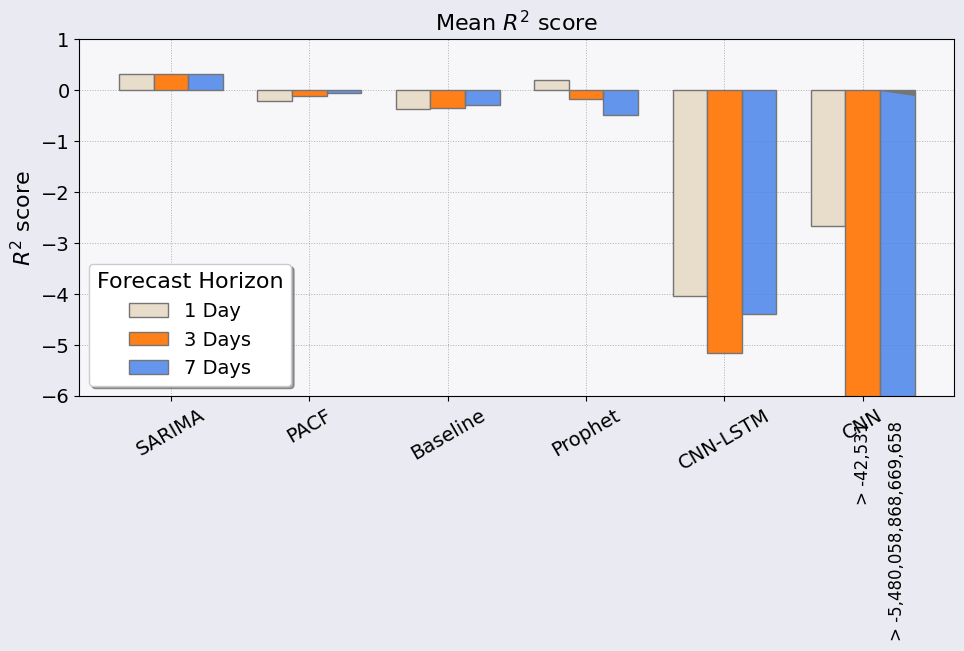

In [31]:
# Setup (same as before)
r2_days = ['r2_1_day', 'r2_3_day', 'r2_7_day']
labels = ['1 Day', '3 Days', '7 Days']
colors = ["#e8dcca", '#ff8019', "#4380ead2"] 

pivot_sorted = pivot.sort_values('r2_7_day', ascending=False)
model_order = list(pivot_sorted['model'])
model_names = [model_display_names.get(m, m) for m in model_order]
r2_values = [pivot_sorted[col].values for col in r2_days]
x = np.arange(len(model_order))
width = 0.25
y_limit = -6

plt.figure(figsize=(10, 7))

# Plot bars
for i, (r2, color, label) in enumerate(zip(r2_values, colors, labels)):
    positions = x + i*width - width
    bars = plt.bar(positions, r2, width, label=label, color=color, edgecolor="#757575", zorder=2)
    
    # Add label only for bars exceeding limit
    for pos, val in zip(positions, r2):
        if val < y_limit:
            text_val = f'> {val:,.0f}'
            plt.text(pos, y_limit - 0.5, text_val, ha='center', va='top', fontsize=12, color='black', rotation=90)

plt.grid(True, which='both', axis='y', linestyle=':', linewidth=0.7, zorder=1)
plt.grid(True, which='both', axis='x', linestyle=':', linewidth=0.7, zorder=1)
plt.xticks(x, model_names, rotation=30, ha='center', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('$R^2$ score', fontsize=16)
plt.ylim(y_limit, 1)
plt.title('Mean $R^2$ score', fontsize=16)
plt.legend(title='Forecast Horizon', fontsize=14, title_fontsize=16, loc='lower left', frameon=True, fancybox=True, shadow=True)
plt.tight_layout(pad=2)
plt.gca().set_facecolor('#f7f7fa')
plt.gcf().patch.set_facecolor('#eaeaf2')

plt.show()



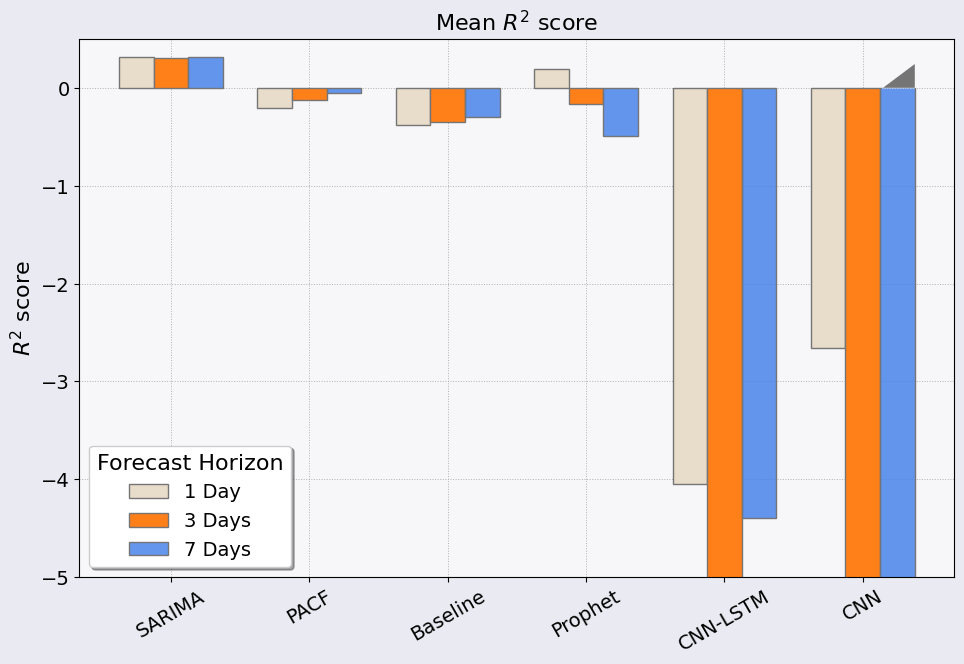

In [35]:
# Define which columns to plot and their display names/colors
r2_days = ['r2_1_day', 'r2_3_day', 'r2_7_day']
labels = ['1 Day', '3 Days', '7 Days']
colors = ["#e8dcca", '#ff8019', "#4380ead2"] 
 

# Sort by r2_day for model order
pivot_sorted = pivot.sort_values('r2_7_day', ascending=False)
model_order = list(pivot_sorted['model'])
model_names = [model_display_names.get(m, m) for m in model_order]
r2_values = [pivot_sorted[col].values for col in r2_days]
x = np.arange(len(model_order))
width = 0.25

plt.figure(figsize=(10, 7))

for i, (r2, color, label) in enumerate(zip(r2_values, colors, labels)):
    plt.bar(x + i*width - width, r2, width, label=label, color=color, edgecolor="#757575", zorder=2) #edgecolor="#757575",

plt.grid(True, which='both', axis='y', linestyle=':', linewidth=0.7, zorder=1)
plt.grid(True, which='both', axis='x', linestyle=':', linewidth=0.7, zorder=1)
plt.xticks(x, model_names, rotation=30, ha='center', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('$R^2$ score', fontsize=16)
plt.ylim(-5, 0.5)
plt.title('Mean $R^2$ score', fontsize=16)
plt.legend(title='Forecast Horizon', fontsize=14, title_fontsize=16, loc='lower left', frameon=True, fancybox=True, shadow=True)
plt.tight_layout(pad=2)
plt.gca().set_facecolor('#f7f7fa')
plt.gcf().patch.set_facecolor('#eaeaf2')

plt.show()

# RMSE

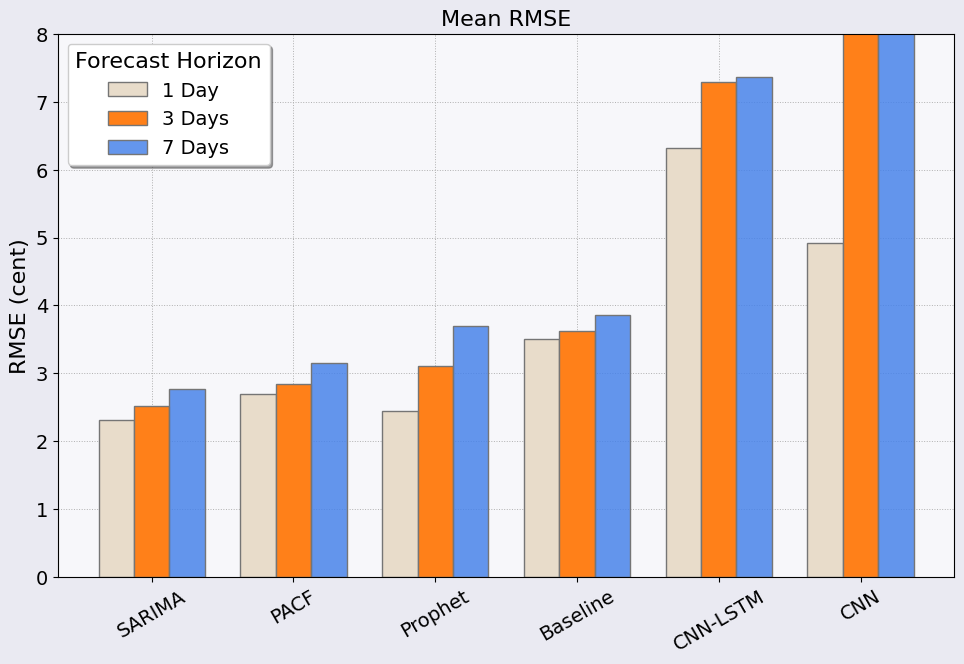

In [38]:
# Define which columns to plot and their display names/colors
rmse_days = ['rmse_1_day', 'rmse_3_day', 'rmse_7_day']
labels = ['1 Day', '3 Days', '7 Days']
colors = ["#e8dcca", '#ff8019', "#4380ead2"] 

# Sort by rmse_1_day for model order
pivot_sorted = pivot.sort_values('rmse_7_day')
model_order = list(pivot_sorted['model'])
model_names = [model_display_names.get(m, m) for m in model_order]
rmse_values = [pivot_sorted[col].values for col in rmse_days]
x = np.arange(len(model_order))  # label locations
width = 0.25  # width of the bars

plt.figure(figsize=(10, 7))
for i, (rmse, color, label) in enumerate(zip(rmse_values, colors, labels)):
    plt.bar(x + i*width - width, rmse, width, label=label, color=color, edgecolor="#757575", zorder=2)
plt.grid(True, which='both', axis='y', linestyle=':', linewidth=0.7, zorder=1)
plt.grid(True, which='both', axis='x', linestyle=':', linewidth=0.7, zorder=1)
plt.xticks(x, model_names, rotation=30, ha='center', fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('RMSE (cent)', fontsize=16)
plt.ylim(0, 8)
plt.title('Mean RMSE', fontsize=16)
plt.legend(title='Forecast Horizon', fontsize=14, title_fontsize=16, loc='upper left', frameon=True, fancybox=True, shadow=True)
plt.tight_layout(pad=2)
plt.gca().set_facecolor('#f7f7fa')
plt.gcf().patch.set_facecolor('#eaeaf2')

plt.show()

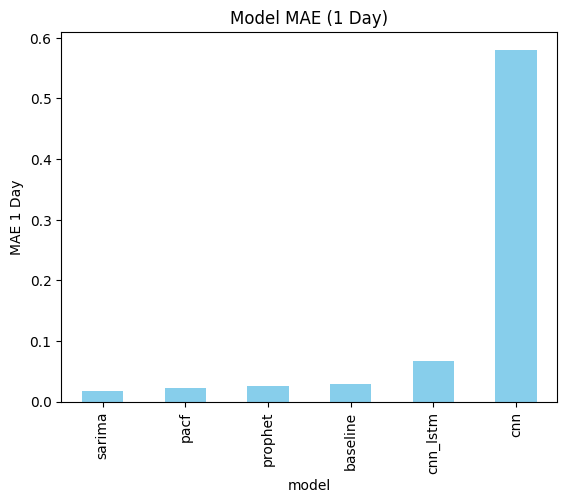

In [ ]:
pivot[('mean', 'mae_3_day')].sort_values().plot(kind='bar', color='skyblue')
plt.ylabel('MAE 1 Day')
plt.title('Model MAE (1 Day)')
plt.show()

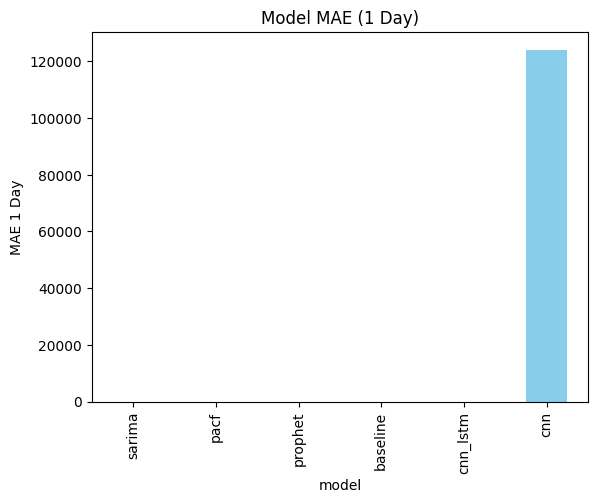

In [ ]:
pivot[('mean', 'mae_7_day')].sort_values().plot(kind='bar', color='skyblue')
plt.ylabel('MAE 1 Day')
plt.title('Model MAE (1 Day)')
plt.show()

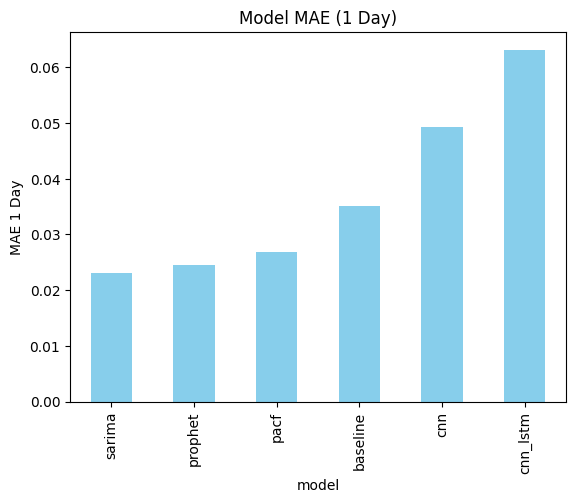

In [ ]:
pivot[('mean', 'rmse_1_day')].sort_values().plot(kind='bar', color='skyblue')
plt.ylabel('MAE 1 Day')
plt.title('Model MAE (1 Day)')
plt.show()

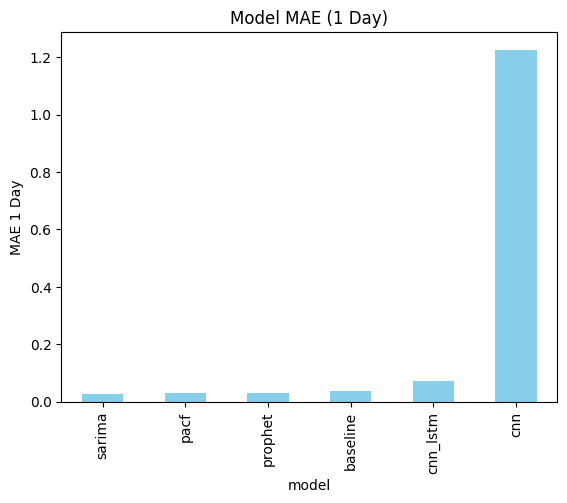

In [ ]:
pivot[('mean', 'rmse_3_day')].sort_values().plot(kind='bar', color='skyblue')
plt.ylabel('MAE 1 Day')
plt.title('Model MAE (1 Day)')
plt.show()

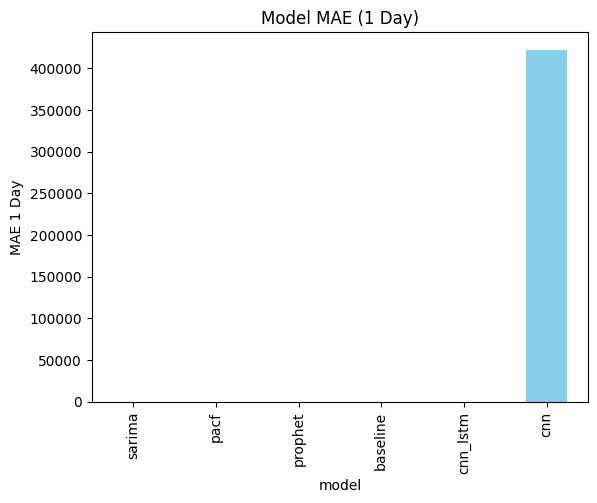

In [ ]:
pivot[('mean', 'rmse_7_day')].sort_values().plot(kind='bar', color='skyblue')
plt.ylabel('MAE 1 Day')
plt.title('Model MAE (1 Day)')
plt.show()

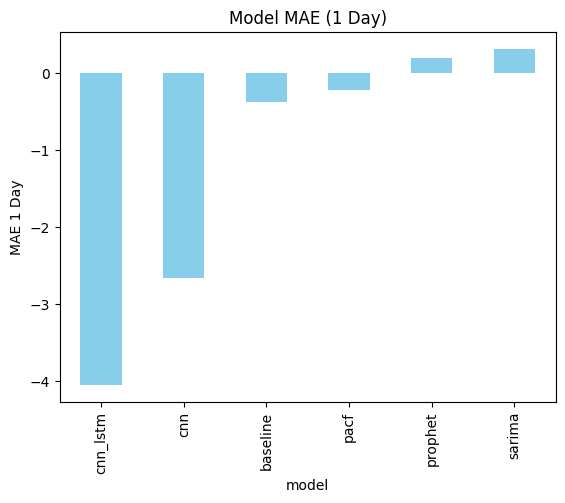

In [ ]:
pivot[('mean', 'r2_1_day')].sort_values().plot(kind='bar', color='skyblue')
plt.ylabel('MAE 1 Day')
plt.title('Model MAE (1 Day)')
plt.show()

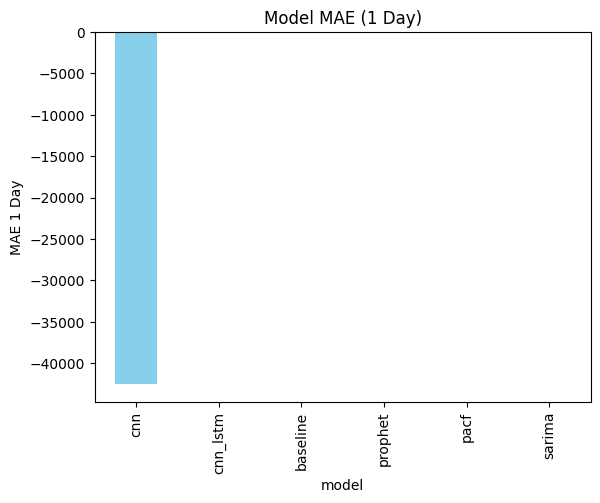

In [ ]:
pivot[('mean', 'r2_3_day')].sort_values().plot(kind='bar', color='skyblue')
plt.ylabel('MAE 1 Day')
plt.title('Model MAE (1 Day)')
plt.show()

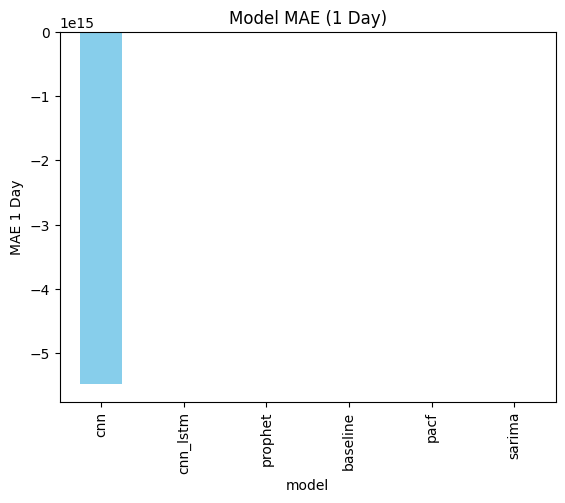

In [ ]:
pivot[('mean', 'r2_7_day')].sort_values().plot(kind='bar', color='skyblue')
plt.ylabel('MAE 1 Day')
plt.title('Model MAE (1 Day)')
plt.show()